In [1]:
%run preprocessing.ipynb
%run evaluation.ipynb

In [67]:
import pandas as pd
import io
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sn
import numpy as np

In [68]:
import gensim
import gensim.downloader as api
from os import path
from gensim.models import Word2Vec


fns = [_removeNumbers, _removeStopWords, _cleanLinks, _cleanAbbreviations, _removeSpecialChars, _removePunctuation, _lemmatization]


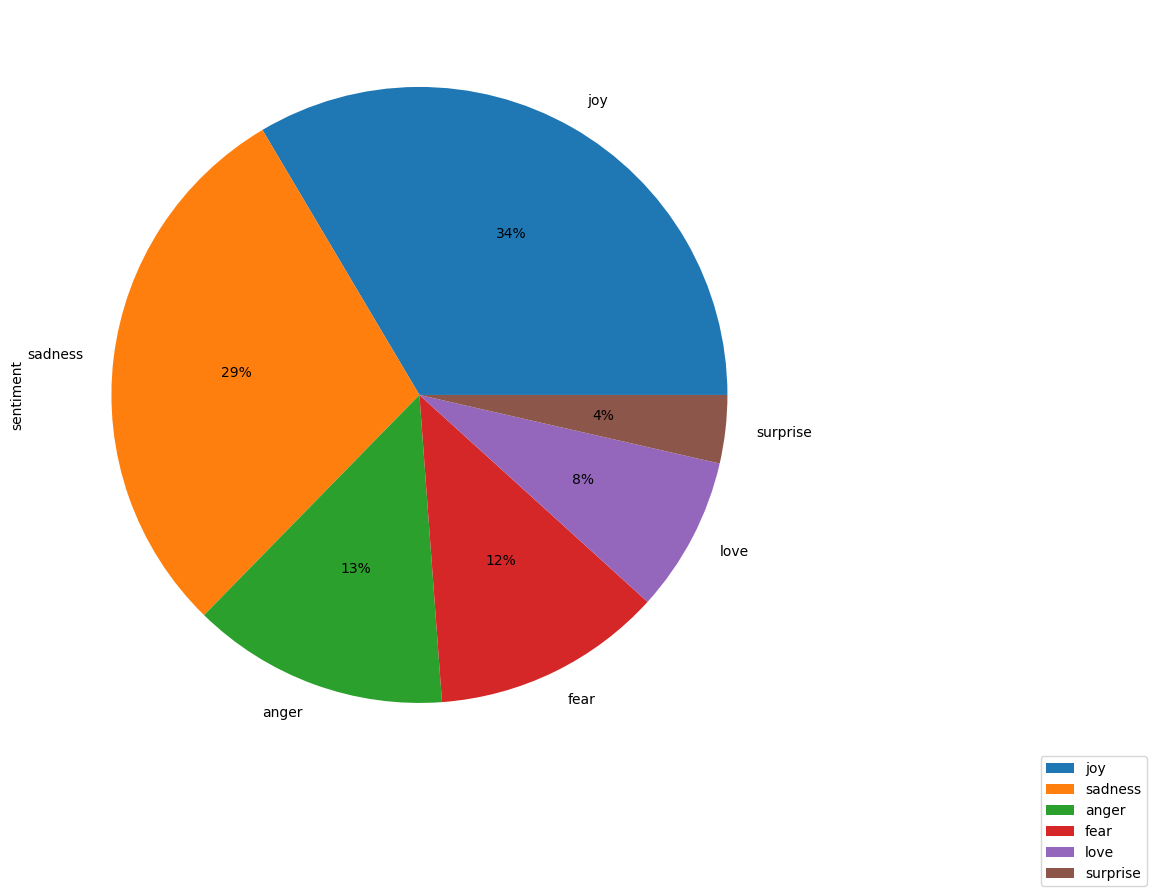

In [69]:
train = pd.read_csv('train.txt', sep=';', names=['text', 'sentiment'])
test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
val = pd.read_csv('val.txt', sep=';', names=['text', 'sentiment'])
_saveClassDistribution(train)

In [70]:
xtrain, ytrain = preprocess(train, fns)
xtest, ytest = preprocess(test, fns)
xval, yval = preprocess(val, fns)

In [71]:
Embedding_dimensions = 100

Word2vec_train_data = list(map(lambda x: x.split(), xtrain))

In [72]:
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=10,
                 min_count=5)

In [73]:
print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 3217


In [74]:
input_length = 80

In [75]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [76]:
vocab_length = 50000
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(xtrain)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 50000


In [77]:
X_train = pad_sequences(tokenizer.texts_to_sequences(xtrain), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(xtest) , maxlen=input_length)
X_val  = pad_sequences(tokenizer.texts_to_sequences(xval) , maxlen=input_length)

In [78]:
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)
print("X_val.shape :", X_val.shape)

X_train.shape: (16000, 80)
X_test.shape : (2000, 80)
X_val.shape : (2000, 80)


In [79]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (50000, 100)


In [80]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [89]:
embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)


In [90]:
def _makeModel3(layer):
    model = Sequential()
    model.add(layer)
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
    model.add(Conv1D(100, 5, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [93]:
model = _makeModel3(embedding_layer)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 80, 100)           5000000   
                                                                 
 bidirectional_26 (Bidirecti  (None, 80, 200)          160800    
 onal)                                                           
                                                                 
 bidirectional_27 (Bidirecti  (None, 80, 200)          240800    
 onal)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 76, 100)           100100    
                                                                 
 global_max_pooling1d_13 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                     

In [94]:
hist = model.fit(
    X_train, ytrain,
    batch_size=1024,
    epochs=15,
    validation_data=(X_val, yval),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
16/16 [==============================] - 13s 542ms/step - loss: 1.6227 - accuracy: 0.3316 - val_loss: 1.5951 - val_accuracy: 0.3430 - lr: 0.0010
Epoch 2/15
16/16 [==============================] - 6s 404ms/step - loss: 1.5797 - accuracy: 0.3323 - val_loss: 1.5891 - val_accuracy: 0.3495 - lr: 0.0010
Epoch 3/15
16/16 [==============================] - 7s 408ms/step - loss: 1.5780 - accuracy: 0.3352 - val_loss: 1.5785 - val_accuracy: 0.3465 - lr: 0.0010
Epoch 4/15
16/16 [==============================] - 6s 406ms/step - loss: 1.5720 - accuracy: 0.3406 - val_loss: 1.5752 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 5/15
16/16 [==============================] - 7s 411ms/step - loss: 1.5704 - accuracy: 0.3381 - val_loss: 1.5730 - val_accuracy: 0.3575 - lr: 0.0010
Epoch 6/15
16/16 [==============================] - 7s 416ms/step - loss: 1.5673 - accuracy: 0.3494 - val_loss: 1.5738 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 7/15
16/16 [==============================] - 7s 418ms/step - l

In [95]:
model.save('model\emotions.tf', save_format='tf')
print("Model saved on disk.")

INFO:tensorflow:Assets written to: model\emotions.tf\assets


INFO:tensorflow:Assets written to: model\emotions.tf\assets


Model saved on disk.


In [96]:
def _testModel3(model, xtest, ytest):
    print("Testing the model...")
    print("The result obtained is:\n")
    model.evaluate(xtest, ytest)

    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    result = confusion_matrix(ytest, yprediction, normalize='pred')
    print(result)

    classes = ["joy", "anger", "love", "sadness", "fear", "surprise"]
    df_cfm = pd.DataFrame(result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig("evaluation\cfm.png")
    print("\nConfusion matrix saved on disk.\n")

    getClassificationReport3(yprediction, ytest)

def getClassificationReport3(yprediction, ytest):
    # yprediction = np.argmax(yprediction, axis=1)
    # ytest = np.argmax(ytest, axis=1)
    report = classification_report(ytest, yprediction)
    print(report)
    with io.open('evaluation/classificationreport.txt', 'w', encoding='utf-8') as f:
        f.write(report)


Testing the model...
The result obtained is:

63/63 [==============================] - 2s 13ms/step
[[0.37097878 0.         0.         0.283859   0.         0.        ]
 [0.12594114 0.         0.         0.16883117 0.         0.        ]
 [0.08829569 0.         0.         0.05565863 0.         0.        ]
 [0.28952772 0.         0.         0.29313544 0.         0.        ]
 [0.09445585 0.         0.         0.15955473 0.         0.        ]
 [0.03080082 0.         0.         0.03896104 0.         0.        ]]

Confusion matrix saved on disk.

              precision    recall  f1-score   support

           0       0.37      0.78      0.50       695
           1       0.00      0.00      0.00       275
           2       0.00      0.00      0.00       159
           3       0.29      0.27      0.28       581
           4       0.00      0.00      0.00       224
           5       0.00      0.00      0.00        66

    accuracy                           0.35      2000
   macro avg     

c:\Users\Tea_W\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tea_W\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tea_W\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


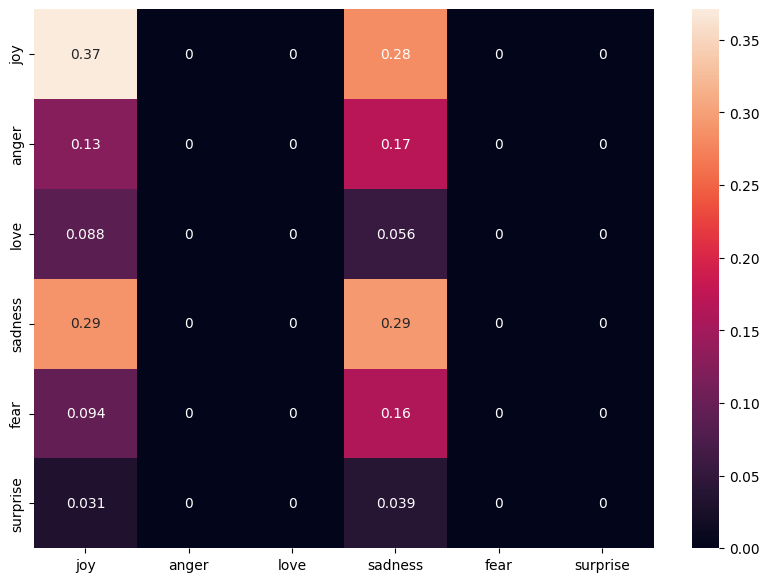

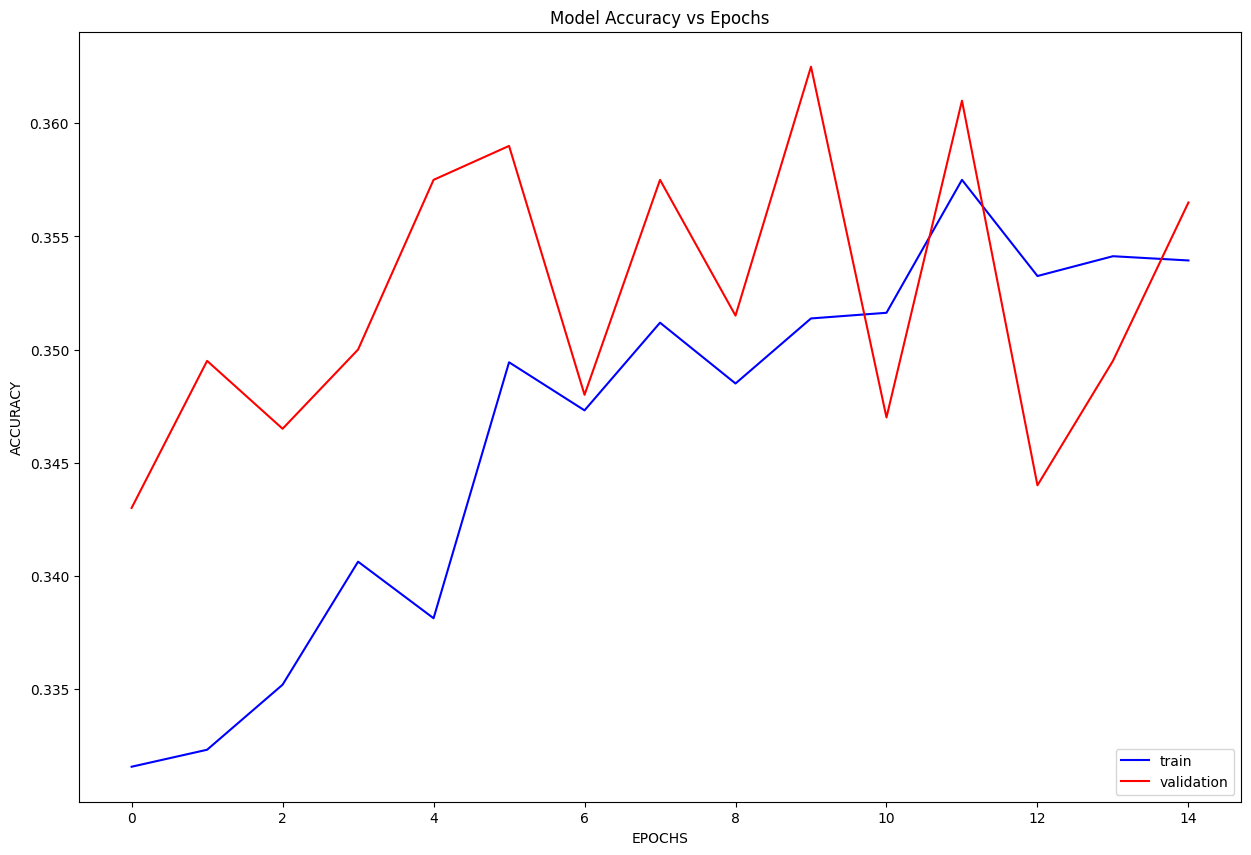

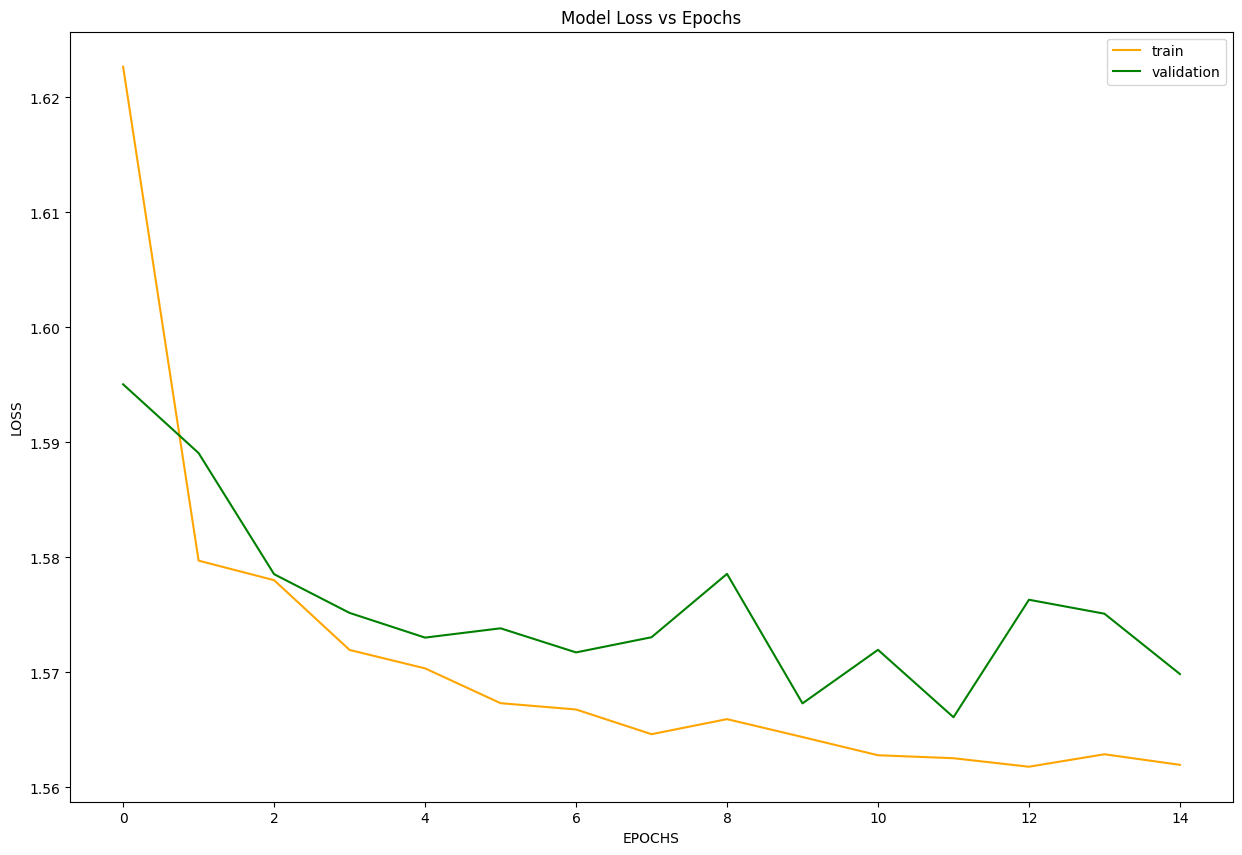

In [97]:
_testModel3(model, X_test, ytest)
_saveFigures(hist)
plot_model(model=model, to_file='model\model.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)
